In [1]:
] activate .

  Activating project at `~/.julia/dev/HJB/examples`


In [2]:
] st

Status `~/.julia/dev/HJB/examples/Project.toml`
⌃ [a6e380b2] ControlSystems v1.8.2
⌃ [aaaaaaaa] ControlSystemsBase v1.9.6
⌃ [0c46a032] DifferentialEquations v7.11.0
  [f6369f11] ForwardDiff v0.10.36
  [a3cb4e6c] HJB v1.0.0-DEV `~/.julia/dev/HJB`
⌃ [6fe1bfb0] OffsetArrays v1.12.10
⌃ [7f7a1694] Optimization v3.19.3
⌃ [36348300] OptimizationOptimJL v0.1.13
⌃ [91a5bcdd] Plots v1.39.0
  [49802e3a] ProgressBars v1.5.1
  [5d786b92] TerminalLoggers v0.1.7
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [ ]:
] up

    Updating registry at `~/.julia/registries/General.toml`
   Installed ConcurrentUtilities ─────── v2.3.1
   Installed FFTW ────────────────────── v1.8.0
   Installed Static ──────────────────── v0.8.10
   Installed RecursiveArrayTools ─────── v3.8.0
   Installed StaticArrays ────────────── v1.9.2
   Installed NonlinearSolve ──────────── v3.5.4
   Installed SteadyStateDiffEq ───────── v2.0.1
   Installed DifferentialEquations ───── v7.12.0
   Installed BoundaryValueDiffEq ─────── v5.6.0
   Installed Functors ────────────────── v0.4.7
   Installed DiffEqBase ──────────────── v6.146.1
   Installed BandedMatrices ──────────── v1.5.0
   Installed LinearMaps ──────────────── v3.11.2
   Installed CodecBzip2 ──────────────── v0.8.2
   Installed MathOptInterface ────────── v1.25.2
   Installed SimpleNonlinearSolve ────── v1.4.1
   Installed Random123 ───────────────── v1.6.2
   Installed ControlSystemsBase ──────── v1.10.2
   Installed OptimizationOptimJL ─────── v0.2.2
   Installed JumpProc

In [3]:
using Revise

In [4]:
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

Precompiling TerminalLoggers
  ✓ ProgressLogging
  ✓ LeftChildRightSiblingTrees
  ✓ TerminalLoggers
  3 dependencies successfully precompiled in 3 seconds. 1 already precompiled.


Logging.ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(43) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [5]:
using HJB

Precompiling HJB
  ✓ Adapt
  ✓ Adapt → AdaptStaticArraysExt
  ✓ GPUArraysCore
  ✓ ArrayInterface
  ✓ OffsetArrays
  ✓ ArrayInterface → ArrayInterfaceGPUArraysCoreExt
  ✓ ArrayInterface → ArrayInterfaceStaticArraysCoreExt
  ✓ ArrayLayouts
  ✓ ArrayLayouts → ArrayLayoutsSparseArraysExt
  ✓ BandedMatrices
  ✓ BandedMatrices → BandedMatricesSparseArraysExt
  ✓ ArrayInterface → ArrayInterfaceBandedMatricesExt
  ✓ RecursiveArrayTools
  ✓ SciMLOperators
  ✓ SciMLBase
  ✓ HJB
  16 dependencies successfully precompiled in 45 seconds. 38 already precompiled.


In [ ]:
using BenchmarkTools, StaticArrays, Plots, DifferentialEquations, OffsetArrays, LinearAlgebra

Precompiling Plots
  ✓ Libtiff_jll
  ✓ MbedTLS
  ✓ FFMPEG_jll
  ✓ Qt6Base_jll
  ✓ OpenSSL
  ✓ Latexify
  ✓ FFMPEG
  ✓ UnitfulLatexify
  ✓ GR_jll
  ✓ HTTP
  ✓ GR
  ✓ Plots
  ✓ Plots → UnitfulExt
  13 dependencies successfully precompiled in 80 seconds. 140 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
Precompiling DifferentialEquations
  ✓ CEnum
  ✓ EnzymeCore
  ✓ MKL
  ✓ PreallocationTools
  ✓ Sparspak
  ✓ FiniteDiff
  ✓ StaticArrayInterface
  ✓ StaticArrayInterface → StaticArrayInterfaceStaticArraysExt
  ✓ FiniteDiff → FiniteDiffBandedMatricesExt
  ✓ StaticArrayInterface → StaticArrayInterfaceOffsetArraysExt
  ✓ FiniteDiff → FiniteDiffStaticArraysExt
  ✓ CloseOpenIntervals
  ✓ LayoutPointers
  ✓ Distributions
  ✓ NLSolversBase
  ✓ SparseDiffTools
  ✓ StrideArraysCore
  ✓ Distributions → DistributionsTestExt
  ✓ LineSearches
  ✓ Po

In [7]:
Threads.nthreads()

InterruptException: InterruptException:

In [ ]:
function plot_grid!(data, grid::HJB.Grid{2, F}) where {F}
    # for now only supports plotting 2 dimensional problems

    x1s = HJB.getDomainAxes(grid, 1)
    x2s = HJB.getDomainAxes(grid, 2)

    heatmap!(x1s, x2s, data[HJB.DomainIndices(grid)]')

end

plot_grid! (generic function with 1 method)

In [10]:
# define the dynamics
function f(t, x, u)
    return @SVector [x[2], u[1]]
end

# define the Hamiltonian
function H(t, x, V, DxV)
    u1 = @SVector [1.0]
    u2 = @SVector [-1.0]
    H1 = DxV' * f(t, x, u1)
    H2 = DxV' * f(t, x, u2)
    γ = 1.0

    # CBF Hamiltonian!
    return min(0, max(H1, H2) + γ*V)
    # return max(H1, H2) + γ*V
end

# define the constraint function
function l(x)
    xcon = 0.5 - x[1]^2
    return xcon
end

# you need to define some dissipation coefficients
# this is a vector of maximum derivatives of H along each spatial dimension
# function dissipation_coefficients(t, x)
#     return @SVector [1.0, 1.0]
# end

function dissipation_coefficients(t, x)
    return @SVector [abs(x[2]), 1.0]
end

numericalHamiltonianMethod = HJB.LocalLaxFriedrichsNHM(
    HJB.LeftWenoGradient(),
    HJB.RightWenoGradient(), 
    dissipation_coefficients
    )

HJB.LocalLaxFriedrichsNHM{HJB.LeftWenoGradient{Float64}, HJB.RightWenoGradient{Float64}, typeof(dissipation_coefficients)}(HJB.LeftWenoGradient{Float64}(1.0e-6), HJB.RightWenoGradient{Float64}(1.0e-6), dissipation_coefficients)

In [11]:
x1s = -1:0.025:1
x2s = -2:0.025:2
grid = HJB.Grid((x1s, x2s))

HJB.Grid{2, Float64}((-1.0, -2.0), (0.025, 0.025), (81, 161), 3)

In [12]:
prob = HJB.get_ODEProblem(H, l, grid, (0.0, -2.0), numericalHamiltonianMethod)

ODEProblem with uType OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}} and tType Float64. In-place: true
timespan: (0.0, -2.0)
u0: 87×167 OffsetArray(::Matrix{Float64}, -3:83, -3:163) with eltype Float64 with indices -3:83×-3:163:
 0.0  0.0  0.0   0.0        0.0       …   0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0  -0.5       -0.5          -0.5       -0.5       0.0  0.0  0.0
 0.0  0.0  0.0  -0.450625  -0.450625     -0.450625  -0.450625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.4025    -0.4025    …  -0.4025    -0.4025    0.0  0.0  0.0
 0.0  0.0  0.0  -0.355625  -0.355625     -0.355625  -0.355625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.31      -0.31         -0.31      -0.31      0.0  0.0  0.0
 0.0  0.0  0.0  -0.265625  -0.265625     -0.265625  -0.265625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.2225    -0.2225       -0.2225    -0.2225    0.0  0.0  

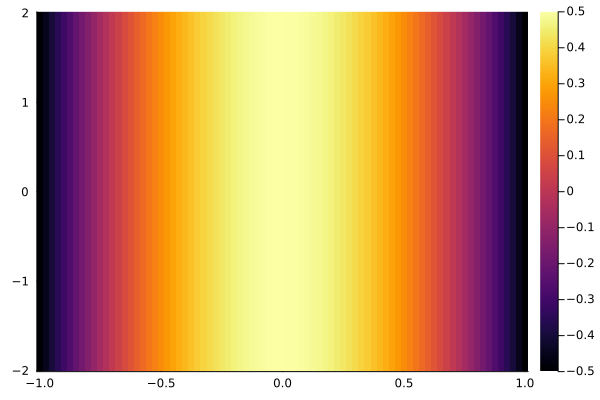

In [13]:
plot()
plot_grid!(prob.u0, grid)

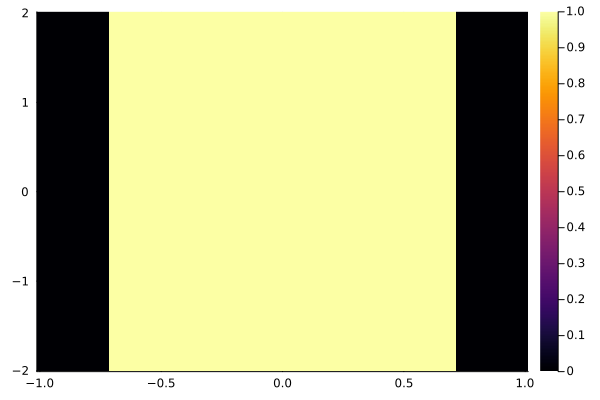

In [14]:
plot()
plot_grid!(prob.u0 .>= 0.0, grid)

In [15]:
# SSPRK54() # good
# SSPRK53() # good
# SSPRK22() # good
# SSPRK43() # very slow
# Tsit5() # good
# unspecified # good

@time sol = solve(prob; reltol=1e-6, abstol=1e-6, progress=true, dt=1e-3, alg=SSPRK53())

LoadError: UndefVarError: `SSPRK53` not defined

In [16]:
plot()
plot_grid!(sol.u[end], grid)

LoadError: UndefVarError: `sol` not defined

In [17]:
plot()
plot_grid!(sol.u[end] .>= 0.0, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

LoadError: UndefVarError: `sol` not defined

In [18]:
ind = HJB.state2ind(grid, [0.4,0.1])

CartesianIndex(56, 84)

In [19]:
sol.u[end][ind]

LoadError: UndefVarError: `sol` not defined

## now define a new constraint function

In [20]:
# define the constraint function
function l2(x)
    # xcon = 1.8 - x[1] 
    # xcon = 0.5 - x[1]^2
    xcon = sqrt(2)/2 - sqrt(x[1]^2 + x[2]^2/4)
    # vcon = 1.5 - x[2]
    # return min(xcon, vcon)
    return xcon
end

l2 (generic function with 1 method)

In [21]:
prob2 = HJB.get_ODEProblem(H, l2, grid, (0.0, -2.0), numericalHamiltonianMethod)

ODEProblem with uType OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}} and tType Float64. In-place: true
timespan: (0.0, -2.0)
u0: 87×167 OffsetArray(::Matrix{Float64}, -3:83, -3:163) with eltype Float64 with indices -3:83×-3:163:
 0.0  0.0  0.0   0.0        0.0       …   0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0  -0.707107  -0.698296     -0.698296  -0.707107  0.0  0.0  0.0
 0.0  0.0  0.0  -0.689541  -0.680618     -0.680618  -0.689541  0.0  0.0  0.0
 0.0  0.0  0.0  -0.672205  -0.663169  …  -0.663169  -0.672205  0.0  0.0  0.0
 0.0  0.0  0.0  -0.655106  -0.645957     -0.645957  -0.655106  0.0  0.0  0.0
 0.0  0.0  0.0  -0.638256  -0.628991     -0.628991  -0.638256  0.0  0.0  0.0
 0.0  0.0  0.0  -0.621661  -0.61228      -0.61228   -0.621661  0.0  0.0  0.0
 0.0  0.0  0.0  -0.605334  -0.595835     -0.595835  -0.605334  0.0  0.0  

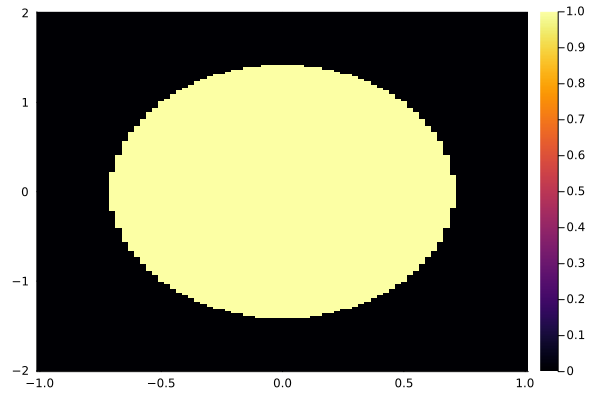

In [22]:
plot()
plot_grid!(prob2.u0 .>= 0.0, grid)

In [23]:
@time sol2 = solve(prob2; reltol=1e-6, abstol=1e-6, progress=true, dt=1e-3, alg=SSPRK53())

LoadError: UndefVarError: `SSPRK53` not defined

In [24]:
plot()
plot_grid!(sol2.u[end], grid)

LoadError: UndefVarError: `sol2` not defined

In [25]:
plot()
plot_grid!(sol2.u[end] .>= 0.0, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

LoadError: UndefVarError: `sol2` not defined